# 2-Dimensional Gaussian Mixture Models (GMMs)

__Objective__:

Today our goal is to use a hands-on approach to help us become more familiar with gaussians. We'll turn the 2-dimensional gaussian equations in lecture __23 Breaking K-Means, Meeting EM__ into Python code, using Numpy and Matplotlib to visualize gaussians and probabilities. It will be helpful to have these slides open while you complete today's challenge.

## Part 0: Visualizing Surfaces

When working with 3D data (e.g. 2D data + probability on the Z axis), it's often useful to visualize it as a surface rather than scattered points. Here is a function that will help you visualize surfaces in matplotlib. 

You can call this function using the following syntax:

> `ax, cs = interp_contour(X, C, ax=None, filled=False)`

where 

* `X` is an Nx2 dataset, 
* `C` is an Nx1 array of data that represents the color axis (e.g. the probability of each sample in `X`), 
* `ax` is the axis object on which the contour is drawn, and 
* `cs` is a list of colors in the surface, which you can use to define a colorbar, if you like.

__To do__: Run the code cell below to see what `interp_contour()` does.

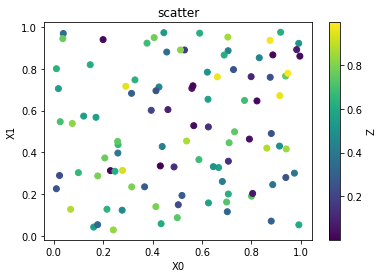

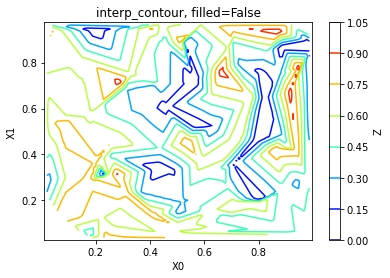

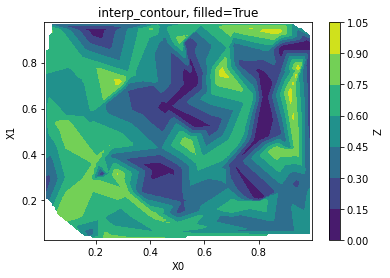

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
np.set_printoptions(precision=3, suppress=True)

def interp_contour(X, C, ax=None, filled=False):
    '''Given X with at least 2 columns (X- and Y- axes) and C with 1 column 
    (color axis) uses linear interpolation to fit a surface contour to the data,
    like a topographic map. To fill in colors between lines, pass filled=True.'''

    if ax == None:
        fig, ax = plt.subplots()
        
    ax.set_xlabel("X0")
    ax.set_ylabel("X1")

    N = X.shape[0]
    MeshN = N**2
    number_line_0 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), N).reshape((N,1))
    number_line_1 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), N).reshape((N,1))
    MeshX0, MeshX1 = np.meshgrid( number_line_0, number_line_1 )
    MeshC = griddata( X, C, (MeshX0, MeshX1)).reshape(MeshX0.shape)
    
    if filled:
        cs = ax.contourf(MeshX0, MeshX1, MeshC)
    else:
        cs = ax.contour(MeshX0, MeshX1, MeshC, cmap="jet")

    return ax, cs

# Demo interpolated contour functions
N = 100
X = np.random.random((N,2))
Z = np.random.uniform(size=(N,1))

# Visulaize raw data
plt.scatter(X[:,0], X[:,1], c=Z)
plt.xlabel("X0")
plt.ylabel("X1")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z')
plt.title("scatter")

# Visualize contours
ax, cs = interp_contour(X, Z, filled=False)
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('Z')
ax.set_title("interp_contour, filled=False")

ax, cs = interp_contour(X, Z, filled=True)
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('Z')
ax.set_title("interp_contour, filled=True")
plt.show()

## Part 1: 2-Dimensional Gaussian

### 1.A: The Gaussian Surface
Let's get a feel for how the mean and covariance shape a 2D __gaussian__ surface (a.k.a. multivariate __normal distribution__) in 2D. 

In a 2D gaussian surface, the X axis describes possible values along dimension $X_0$, the Y axis describes possible values along dimension $X_1$, and the Z axis describes the probability $p(x)$ of seeing each possible value, $x$.

__TO DO:__

1. Complete the `gauss_2D()` function below so that it calculates the probability of each value in X, using the equation from slide 45 (copied below). You'll know that your `gauss_2D()` is working when `test_gauss_2D()` draws a contour plot with an elliptical peak (see slide 45 for an example). 
> $p(x) = \frac{1}{(2 \pi)^{M/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu))$

2. Call your completed `gauss_2D()` function to find the probabilities of the samples at $\pm0$, $\pm1$, $\pm2$, and $\pm3$ standard deviations from the mean. Superimpose them on the graph of $p(x)$.

2. Add to `test_gauss_2D()` so that it visualizes a few more gaussians on the same axes. Play with the mean and variance until you have a feel for how they shape the curve (probability distribution).

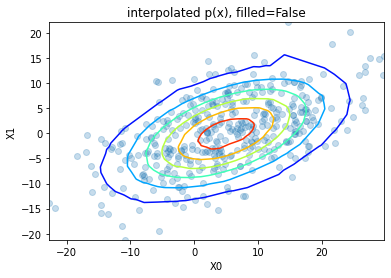

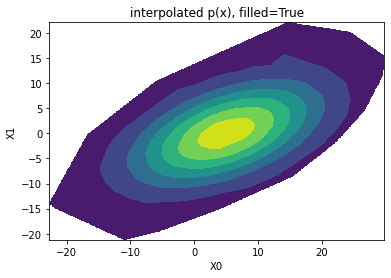

In [240]:
def gauss_2D( X, mu, cov ):
    ''' Returns the probability of each value in the 2-dimensional dataset X, 
    given the shape parameters mu (the 1x2 mean) and cov (the 2x2 covariance matrix).'''
    
    # TODO: This doesn't look right... let's fix it.
    N = X.shape[0]
    M = X.shape[1]
    coeff = 1 / ((2 * np.pi)**(M/2) * np.linalg.det(cov)**(1/2))
    exponent = np.zeros((N,1))
    for n in range(N):
        x_n = X[n, :]
        exponent[n, 0] = -0.5 * (x_n - mu) @ np.linalg.inv(cov) @ (x_n - mu).T

    P = coeff * np.exp(exponent)

    return P


def test_gauss_2D( ):

    # Shape parameters of our first gaussian
    mu = np.array([5.0, 0.0])
    cov = np.array([[10**2, 6**2], [6**2, 7**2]])

    # Test dataset 
    M = 2           # 2-dimensional
    N = 20**M      # number of samples
    X = np.random.multivariate_normal( mu, cov, (N,) )

    # Calculate the probability of each sample in X appearing in this distribution
    P = gauss_2D( X, mu, cov )

    # Visualize an interpolated contour with probability on the color axis
    ax, cs = interp_contour( X, P, filled=False )
    ax.scatter(X[:,0], X[:,1], alpha=0.25 )
    '''cbar = plt.colorbar(cs)
    cbar.ax.set_title('p(x)')'''
    ax.set_title("interpolated p(x), filled=False")

    # Visualize an interpolated filled surface with probability on the color axis
    ax, cs = interp_contour( X, P, filled=True )
    '''cbar = plt.colorbar(cs)
    cbar.ax.set_title('p(x)')'''
    ax.set_title("interpolated p(x), filled=True")

    # Try it out with a few different shape parameters

    plt.show()

test_gauss_2D()

### 1.B: Calculating Mean and Covariance from 2D Data
Now let's see how to fit a gaussian surface to normally distributed 2-dimensional data.

The cell below already does the following for you:
1. Uses `np.random.multivariate_normal()` to generate a normally distributed dataset.
2. Visualizes the randomly generated data with a scatter plot, surface contour, and histogram.

__To do:__

Run this code cell a few times to see how the results change depending on the randomly generated data.

mean input = [5. 0.]
mean observed  = [5.063 0.217]
cov input =
[[100  36]
 [ 36  49]]
cov observed  =
[[100.126  36.866]
 [ 36.866  51.104]]


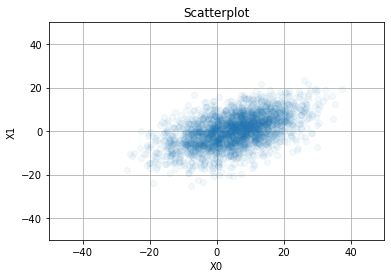

In [241]:
# Shape parameters used to generate the random data
mu = np.array([5.0, 0.0])
cov = np.array([[10**2, 6**2], [6**2, 7**2]])

# Randomly generated data
N = 50**2
M = 2
X = np.random.multivariate_normal(mu, cov, (N,))
xmin = np.min(X)
xmax = np.max(X)

# How significantly do the observed mean and variance of randomly generated data
# differ from the mean and variance supplied as input to multivariate_normal()?
mu_observed = np.mean(X, axis=0)
print("mean input =", mu)
print("mean observed  =", mu_observed)

cov_observed = np.cov(X, rowvar=False)
print("cov input =")
print(cov)
print("cov observed  =")
print(cov_observed)

# Scatterplot of randomly generated data
fig, ax = plt.subplots()
ax.set_title("Scatterplot")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.grid(True)
ax.plot(X[:,0], X[:,1],'o', alpha=0.05)
plt.show()

###1.C: Calculating Mean and Covariance from 2D Data

Let's visualize the probability distribution of our 2D gaussian with a contour plot. 

**To do:**

In the cell below:

1. Use your `gauss_2D()` function to compute the probability of each sample in $X$.

2. Use `interp_contour()` to visualize the 2D gaussian's probability distribution.

3. Superimpose a scatter plot of $X$ to see how the distribution of the generated data aligns with the probability of each sample.

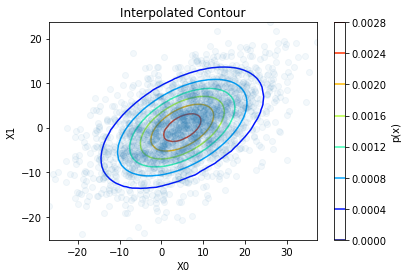

In [242]:
# Contour plot of the 2D gaussian's probability distribution
fig, ax = plt.subplots()
P = gauss_2D(X, mu, cov)
ax, cs = interp_contour(X, P, ax=ax)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('p(x)')
ax.set_title('Interpolated Contour')

# Scatter the original dataste
ax.plot(X[:, 0], X[:, 1], 'o', alpha = 0.05)

**To do:**

Let's visualize the distribution of the generate data using a 2D histogram, `hist2d()`.

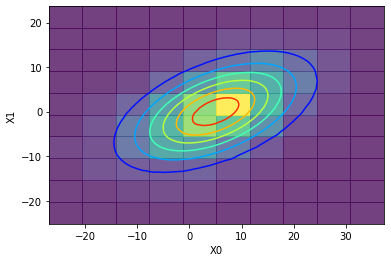

In [243]:
# 2D histogram of generated data
fig, ax = plt.subplots()
ax.hist2d(X[:, 0], X[:, 1], alpha = 0.75)
ax, cs = interp_contour(X, P, ax = ax)

## Part 2: 2-D Gaussian Mixture Model (GMM)

The code cell below generates a dataset using 2 overlapping gaussian surfaces. 

__To do__: Run the cell below before moving on to the next step, so that your data exists :)

In [244]:
# Shape parameters for 2 gaussian distributions, A and B
mu_A = np.array([5, 5])
mu_B = np.array([0, -15])
cov_A = np.array([[10**2, 6**2], [6**2, 7**2]])
cov_B = np.array([[10**2, -6**2], [-6**2, 7**2]])

# Generate random dataset from 2 gaussian distributions
N_A = 250
N_B = 250
N = N_A + N_B
M = 2
X_A = np.random.multivariate_normal( mu_A, cov_A, (N_A,))
X_B = np.random.multivariate_normal( mu_B, cov_B, (N_B,))
X = np.vstack( (X_A, X_B) )
in_A_true = np.where( np.vstack((np.ones((N_A,1)), np.zeros((N_B,1)))), True, False ).flatten()

### 2.A: Cumulative Probability

Let's see how the presence of a second gaussian impacts the probability of a sample, $x_n$.

__To do__:

1. Visualize the probability of each sample $x_n$ appearing in each gaussian distribution $\mathcal{N}(\mu_k, \Sigma_k)$, as calculated in `gauss_2D()`.

2. Visualize the __cumulative probability__ of each sample $x_n$ appearing at all by summing the weighted probabilities that $x_n$ will appear in each distribution $\mathcal{N}(\mu_k, \sigma_k)$. Use the mixing coefficients $\pi_k$ as weights.

Some helpful equations:

>> __cumulative probability__ (slide 46): $p(x) = \Sigma_k \pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)$

>> __mixing coefficients__ (side 53): $\pi_k = \frac{N_{k}}{N}$, where $N_k$ is the number of points in the $k$-th distribution. This is also called the __prior probability__, since it represents how likely we think it is to observe a sample in cluster $k$ before knowing that sample's coordinates, $x_n$.

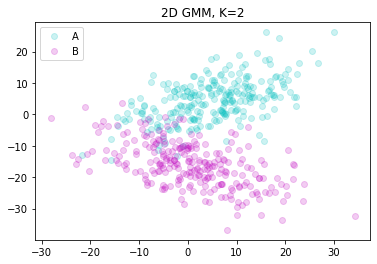

In [245]:
# Visualize the raw data
fig, ax = plt.subplots()
ax.set_title('2D GMM, K=2')
ax.plot(X_A[:, 0], X_A[:, 1], 'oc', alpha = 0.2, label = 'A')
ax.plot(X_B[:, 0], X_B[:, 1], 'om', alpha = 0.2, label = 'B')
plt.legend()

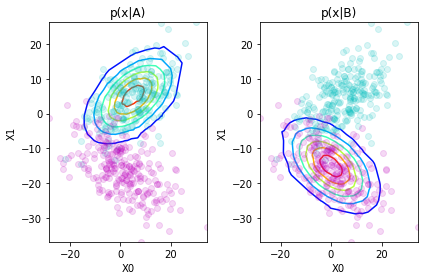

In [246]:
# Let's put the two conditional probabilities -- p(x|A) and p(x|B) -- side by side.
fig, ax = plt.subplots(1,2)

# Probability of each sample X[n,:] appearing in gaussian A: p(x|A) 
ax[0].set_title('p(x|A)')
P_A = gauss_2D(X, mu_A, cov_A)
P_B = gauss_2D(X, mu_B, cov_B)
ax[0].plot(X_A[:, 0], X_A[:, 1], 'oc', alpha = 0.15, label = 'X_A')
ax[0].plot(X_B[:, 0], X_B[:, 1], 'om', alpha = 0.15, label = 'X_B')
interp_contour(X, P_A, ax = ax[0])

# Probability of each sample X[n,:] appearing in gaussian B: p(x|B) 
ax[1].set_title('p(x|B)')
ax[1].plot(X_A[:, 0], X_A[:, 1], 'oc', alpha = 0.15, label = 'X_A')
ax[1].plot(X_B[:, 0], X_B[:, 1], 'om', alpha = 0.15, label = 'X_B')
interp_contour(X, P_B, ax = ax[1])

fig.tight_layout()

In [247]:
# Cumulative probability of each sample X[n,:] appearing at all

# Unfilled contour of the cumulative probability with superimposed scatterplot


In [248]:
# Filled surface visualizing the cumulative probability with superimposed scatterplot


### 2.B: Compute the responsibility of each cluster for each point

__To do__:

Visualize the __responsibility__ of each distribution for each sample.

The equation for responsibility can be found on slides 50 & 52:

> $\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \sigma_k)}{\Sigma_j \pi_j \mathcal{N}(x_n | \mu_j, \sigma_j)}$ 

This is also called the __posterior probability__, since it represents how likely we think it is to observe a sample in cluster $k$ after knowing that sample's coordinates, $x_n$.

In [249]:
# Responsibility of each gaussian for each sample

# Visualize the responsibility of gaussian A for each sample in X

# Visualize the responsibility of gaussian B for each sample in X


In [250]:
# Visualize the filled responsibility surfaces

### 2C: Use responsibility to decide each point's cluster assignment

__To do__:

1. Maximize the responsibility to determine the cluster assignment for each sample in X. 

2. How many samples were swapped into the "wrong" cluster? What is the success rate of our cluster assignment strategy?

>> *Because clustering is unsupervised, we usually won't know which samples have been clustered incorrectly. But this is a useful teaching exercise :)*

In [251]:
# Assign each sample to the cluster with maximum responsibility for that sample


# Which samples have been assigned to the "wrong" gaussian?



# Report your analysis
print("Swapped into A: {0} samples = {1:.1f}% of true B distribution".format( np.sum(swapped_A), np.sum(swapped_A)/N_A*100))
print("Swapped into B: {0} samples = {1:.1f}% of true A distribution".format( np.sum(swapped_B), np.sum(swapped_B)/N_B*100))
print("{0}/{1} = {2:.1f}% of samples misclustered => {3:.1f}% success rate".format( N_swapped, N, N_swapped/N*100, (N-N_swapped)/N*100))

NameError: name 'swapped_A' is not defined

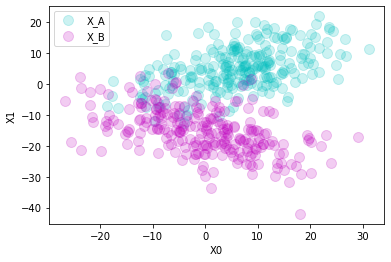

In [91]:
# Visualize the raw data
fig, ax = plt.subplots()
ax.plot( X_A[:,0], X_A[:,1], 'oc', markersize=10, alpha=0.2, label="X_A")
ax.plot( X_B[:,0], X_B[:,1], 'om', markersize=10, alpha=0.2, label="X_B")
ax.set_xlabel("X0")
ax.set_ylabel("X1")

# Superimpose "x"s on samples that have been mis-assigned



ax.legend()
plt.show()

Here is a visual comparison of cluster assignments using 2D histograms:

In [92]:
# Visualize cluster assignments with a histogram
N_A_observed = np.sum(in_A_observed)
N_B_observed = np.sum(~in_A_observed)

fig, ax = plt.subplots(1,2)
ax[0].set_title("Assigned to A")
ax[0].set_xlim(np.min(X[:,0]), np.max(X[:,0]))
ax[0].set_ylim(np.min(X[:,1]), np.max(X[:,1]))
ax[0].hist2d(X[in_A_observed,0], X[in_A_observed,1], weights=np.ones((N_A_observed,))/N_A_observed, label="assigned to A")
interp_contour( X, P_A, ax[0] )

ax[1].set_title("Assigned to B")
ax[1].set_xlim(np.min(X[:,0]), np.max(X[:,0]))
ax[1].set_ylim(np.min(X[:,1]), np.max(X[:,1]))
ax[1].hist2d(X[~in_A_observed,0], X[~in_A_observed,1], weights=np.ones((N_B_observed,))/N_B_observed, label="assigned to B")
interp_contour( X, P_B, ax[1] )

fig.tight_layout()

NameError: name 'in_A_observed' is not defined